# DCGAN for CIFAR10 image generation
#### Original Paper (DCGAN): https://arxiv.org/pdf/1511.06434
#### Implementation by Zach D.

## Defining the network

In [1]:
import tensorflow as tf
from IPython.display import clear_output, Image
tf.enable_eager_execution()

Slight modification made to GAN architecture to make network work with 32x32 images instead of 64x64 like in the original paper.

Create the generator and discriminator networks

In [2]:
def create_generator():
    dropout_prob = .4

    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(2*2*256, input_shape=(100,)))
    net.add(tf.keras.layers.Reshape(target_shape=(2, 2, 256)))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 2x2
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 4x4
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 8x8
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 16x16
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.Activation('sigmoid')) # size = 32x32
    
    return net

In [3]:
def create_discriminator():
    dropout_prob = .4
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', input_shape=(32, 32, 3)))
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 32x32
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
     # size = 32x32
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 16x16
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 8x8
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(1))
    net.add(tf.keras.layers.Activation('sigmoid'))
    
    return net

Create a trainable discriminator, as well as the full GAN architecture with the discriminator frozen.

In [4]:
d_net = create_discriminator()
g_net = create_generator()

d_model = tf.keras.Sequential([d_net])
d_optim = tf.keras.optimizers.Adam(lr=0.000008, decay=1e-10)
d_model.compile(optimizer=d_optim, loss='binary_crossentropy', metrics=['accuracy'])

for layer in d_net.layers:
    layer.trainable = False
    
gan_model = tf.keras.Sequential([g_net, d_net])
gan_optim = tf.keras.optimizers.Adam(lr=0.00004, decay=1e-10)
gan_model.compile(optimizer=gan_optim, loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Load data

In [5]:
batch_size = 128
(x_train, _), (_,_) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


In [6]:
def preprocess_fn(image):
    x = tf.reshape(tf.cast(image, tf.float32), (32,32,3))
    x /= 255
#     x = 2*x/255 - 1 # convert image to [-1, 1] range
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

real_ds = tf.data.Dataset.from_tensor_slices(x_train)
real_ds = real_ds.shuffle(60000)
real_ds = real_ds.repeat()
real_ds = real_ds.apply(tf.data.experimental.map_and_batch(
        preprocess_fn, batch_size, num_parallel_batches=6, drop_remainder=True))
real_ds = real_ds.prefetch(tf.data.experimental.AUTOTUNE)

## Train network

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os

In [18]:
dtime = datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(dtime)
os.mkdir(dtime + "/imgs")
os.mkdir(dtime + "/weights")

real_iter = real_ds.make_one_shot_iterator()  

for i in range(0,10000):
    # Grab a batch of real data
    real_batch = real_iter.get_next()
    # Make a batch of fake data by feeding the generator some noise and taking its output
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    fake_batch = g_net.predict(noise, batch_size=batch_size)

    # Create the labels for each set of data (0 for fake, 1 for real)
    real_labels = np.ones([batch_size])
    fake_labels = np.zeros([batch_size])
    # Train discriminator on real and fake data
    d_fake_stats = d_model.train_on_batch(fake_batch, fake_labels)
    d_real_stats = d_model.train_on_batch(real_batch, real_labels)
        
    d_loss_avg = (d_real_stats[0] + d_fake_stats[0])/2
    d_acc_avg = (d_real_stats[1] + d_fake_stats[1])/2
    
    # Train the generator on noise
    # We want the generator to fool the discriminator, therefore
    # the generator has succeeded when the output of the GAN is 1
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    y = np.ones([batch_size])
    g_stats = gan_model.train_on_batch(noise, y)
    
    # Save weights and save generator output
    if i % 100 == 0:
        #sample image
        rand_n = random.randint(0,batch_size-1)
        plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
        plt.axis('off')
        plt.imshow(fake_batch[rand_n])
        plt.savefig(f"{dtime}/imgs/epoch_{i*batch_size//60000}_step_{i}.png", bbox_inches='tight', pad_inches = 0)
        plt.close()
        #save weights
        d_net.save(f"{dtime}/weights/d_net_{i}.h5")
        g_net.save(f'{dtime}/weights/g_net_{i}.h5')

    
#     print(f"[{i*batch_size//60000}  {i}/{60000//batch_size}]: [Dis. loss: {d_loss_avg}, acc: {d_acc_avg}] [Gen. loss: {g_stats[0]}, acc: {g_stats[1]}]")
    

KeyboardInterrupt: 

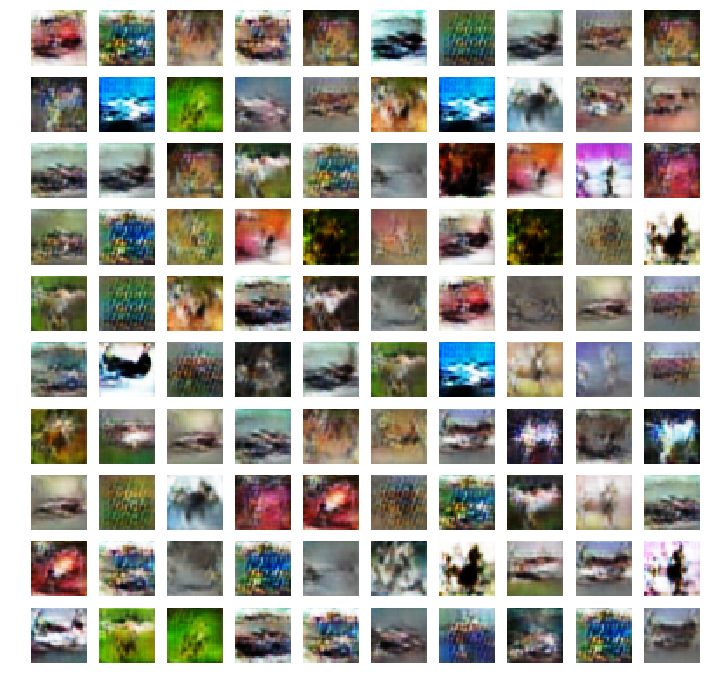

In [67]:
noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
fake_batch = g_net.predict(noise, batch_size=batch_size)

fig = plt.figure(figsize=(12,12))
for i in range(0, 100):
    rand_n = random.randint(0,batch_size-1)
    plt.axis('off')
    ax1 = fig.add_subplot(10,10,i+1)
    ax1.imshow(fake_batch[rand_n])
plt.axis('off')
plt.savefig(f"results.png", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [ ]:
# dtime = datetime.now().strftime("%Y%m%d-%H%M%S")
# os.mkdir(dtime+"-weights")
# d_net.save(f"{dtime}-weights/d_net.h5")
# g_net.save(f'{dtime}-weights/g_net.h5')

In [ ]:
# new_g = tf.keras.models.load_model(f'{dtime}-weights/g_net.h5')

In [ ]:
# noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
# fake_batch = new_g.predict(noise, batch_size=batch_size)
# rand_n = random.randint(0,batch_size-1)
# plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
# plt.imshow(fake_batch[rand_n])

In [ ]:
# real_iter = real_ds.make_one_shot_iterator()
# real_batch = real_iter.get_next()
# plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
# plt.imshow(real_batch[rand_n])

In [ ]:
# noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
# fake_batch = g_net.predict(noise, batch_size=batch_size)
# rand_n = random.randint(0,batch_size-1)
# # plt.imshow((fake_batch[rand_n]+1)/2)
# plt.imshow(fake_batch[rand_n])
# plt.savefig(f"imgs/epoch_{i}.png")
# plt.show()
# print(gan_model.predict(noise, batch_size=batch_size))
# real_iter = real_ds.make_one_shot_iterator()
# real_batch = real_iter.get_next()
# print(d_model(real_batch, training=False))

In [ ]:
d_net = create_discriminator()
g_net = create_generator()

d_net.load_weights("20190702-093622-weights/d_net.h5")
g_net.load_weights("20190702-093622-weights/g_net.h5")

d_model = tf.keras.Sequential([d_net])
d_optim = tf.keras.optimizers.Adam(lr=0.000008, decay=1e-10)
d_model.compile(optimizer=d_optim, loss='binary_crossentropy', metrics=['accuracy'])

for layer in d_net.layers:
    layer.trainable = False
    
gan_model = tf.keras.Sequential([g_net, d_net])
gan_optim = tf.keras.optimizers.Adam(lr=0.00009, decay=1e-10)
gan_model.compile(optimizer=gan_optim, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
dtime = datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(dtime)
os.mkdir(dtime + "/imgs")
os.mkdir(dtime + "/weights")

real_iter = real_ds.make_one_shot_iterator()  

for i in range(0,100000):
    # Grab a batch of real data
    real_batch = real_iter.get_next()
    # Make a batch of fake data by feeding the generator some noise and taking its output
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    fake_batch = g_net.predict(noise, batch_size=batch_size)

    # Create the labels for each set of data (0 for fake, 1 for real)
    real_labels = np.ones([batch_size])
    fake_labels = np.zeros([batch_size])
    # Train discriminator on real and fake data
    d_fake_stats = d_model.train_on_batch(fake_batch, fake_labels)
    d_real_stats = d_model.train_on_batch(real_batch, real_labels)
        
    d_loss_avg = (d_real_stats[0] + d_fake_stats[0])/2
    d_acc_avg = (d_real_stats[1] + d_fake_stats[1])/2
    
    # Train the generator on noise
    # We want the generator to fool the discriminator, therefore
    # the generator has succeeded when the output of the GAN is 1
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    y = np.ones([batch_size])
    g_stats = gan_model.train_on_batch(noise, y)
    
    # Save weights and save generator output
    if i % 100 == 0:
        #sample image
        rand_n = random.randint(0,batch_size-1)
        plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(fake_batch[rand_n])
        plt.savefig(f"{dtime}/imgs/epoch_{i*batch_size//60000}_step_{i}.png")
        plt.close()
        #save weights
        d_net.save(f"{dtime}/weights/d_net_{i}.h5")
        g_net.save(f'{dtime}/weights/g_net_{i}.h5')

    
    print(f"[{i*batch_size//60000}  {i}/{60000//batch_size}]: [Dis. loss: {d_loss_avg}, acc: {d_acc_avg}] [Gen. loss: {g_stats[0]}, acc: {g_stats[1]}]")
    